<a href="https://colab.research.google.com/github/wisecrack7/Indonesian-Stock-Forecasting-using-Bi-LSTM-Bayesian-Optimization/blob/main/Final_Bi_LSTM%2BBO%2BRecursive_Forecast_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y build-essential
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
!pip install yfinance ta-lib scikit-learn tensorflow matplotlib joblib --upgrade --no-cache-dir
!pip install --upgrade --no-cache-dir bayesian-optimization
!pip install --upgrade --no-cache-dir gdown

# =======================
# IMPORT LIBRARIES
# =======================
import os, json, random, joblib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from scipy.stats import zscore
from scipy.stats import pearsonr
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from bayes_opt import BayesianOptimization
from google.colab import drive
warnings.filterwarnings('ignore')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4111    0  4111    0     0   8005      0 --:--:-- --:--:-- --:--:--  8013
100  517k  100  517k    0     0   408k      0  0:00:01  0:00:01 --:--:-- 1652k
--2025-07-02 03:14:48--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9125, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?respo

In [ ]:
# Set seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# ======================= #
# TAHAP: SAMPLE (SAS-style)
# ======================= #

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Mengambil data saham BBRI dari Yahoo Finance
data = yf.download("BBRI.JK", start="2015-01-01", end="2025-03-24")[['Close']]

# 2. Cek dan bersihkan data awal (drop nilai null)
data = data.dropna()
total_len = len(data)

# 3. Membagi data menjadi 80% train, 10% test, 10% validation
train_end = int(total_len * 0.8)
test_end = int(total_len * 0.9)

train_data = data.iloc[:train_end]
test_data  = data.iloc[train_end:test_end]
val_data   = data.iloc[test_end:]

# 4. Menampilkan ringkasan pembagian data
summary = pd.DataFrame({
    "Subset": ["Training", "Testing", "Validation", "Total"],
    "Jumlah Data": [len(train_data), len(test_data), len(val_data), total_len]
})

print("\nRingkasan Pembagian Data Saham BBRI:")
print(summary.to_string(index=False))

print(data.head())

[*********************100%***********************]  1 of 1 completed


Ringkasan Pembagian Data Saham BBRI:
    Subset  Jumlah Data
  Training         2023
   Testing          253
Validation          253
     Total         2529
Price             Close
Ticker          BBRI.JK
Date                   
2015-01-02  1747.007324
2015-01-05  1739.509399
2015-01-06  1728.262573
2015-01-07  1765.752075
2015-01-08  1795.743408



Statistik Deskriptif:
             Close       SMA_20       SMA_50
count  2480.000000  2480.000000  2480.000000
mean   3016.732872  3010.540968  2999.002498
std    1028.115729  1024.902623  1019.793146
min    1244.649048  1388.420898  1457.813801
25%    2207.189880  2217.499490  2204.828081
50%    2954.166504  2968.412671  2962.264458
75%    3798.850037  3818.207834  3804.624259
max    5763.100098  5537.844214  5337.438740

Cek Missing Values:
Close     0
SMA_20    0
SMA_50    0
dtype: int64


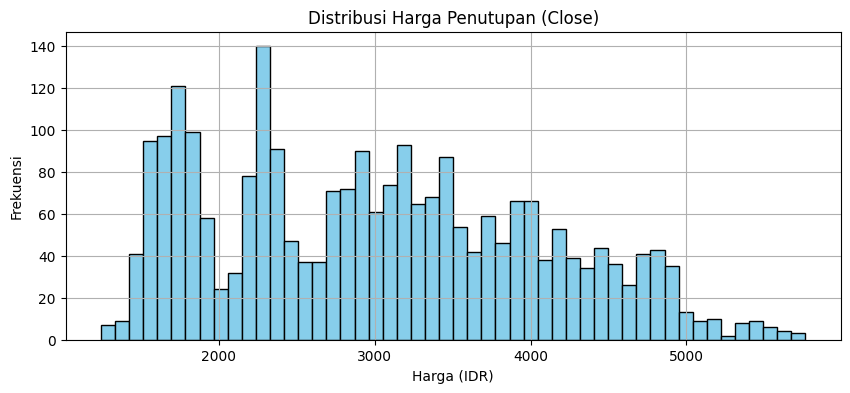

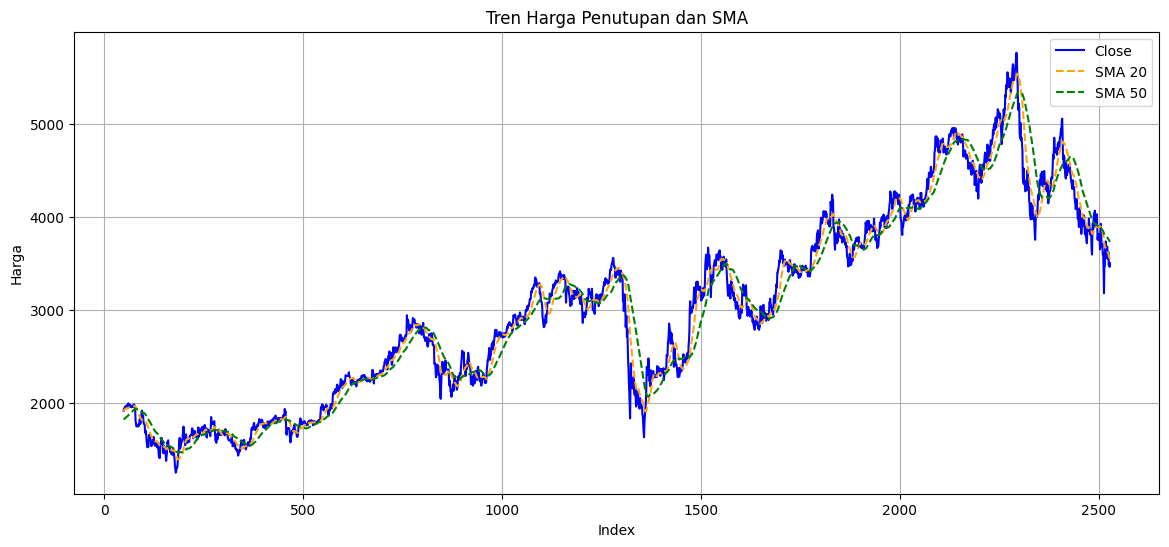

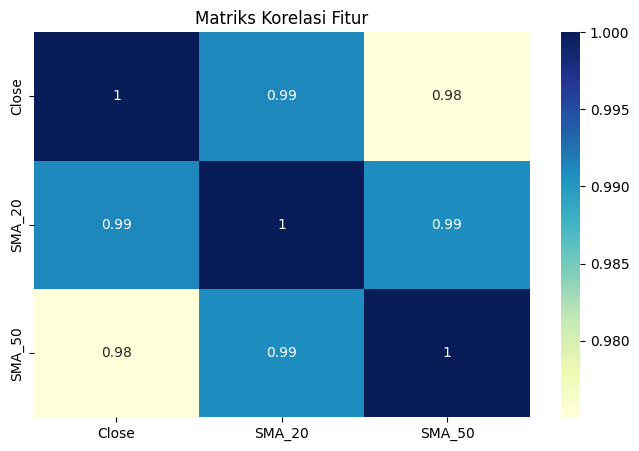


Korelasi Fitur terhadap Close:
Close     1.000000
SMA_20    0.991214
SMA_50    0.975034
Name: Close, dtype: float64

Pasangan Fitur dengan Korelasi Tinggi (Redundant):
- SMA_20 & Close (corr = 0.99)
- SMA_50 & Close (corr = 0.98)
- SMA_50 & SMA_20 (corr = 0.99)


In [ ]:
# ============================ #
# TAHAP: EXPLORE (SAS-style)
# ============================ #
close = data['Close'].astype(float).dropna().values.flatten()
sma_20 = talib.SMA(close, timeperiod=20)
sma_50 = talib.SMA(close, timeperiod=50)

df_feat = pd.DataFrame({
    'Close': close,
    'SMA_20': sma_20,
    'SMA_50': sma_50
}).dropna()

# ========================================= #
# NODE: StatExplore Node (Statistik Univariat)
# ========================================= #
print("\nStatistik Deskriptif:")
print(df_feat.describe())

print("\nCek Missing Values:")
print(df_feat.isnull().sum())

plt.figure(figsize=(10, 4))
plt.hist(df_feat['Close'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribusi Harga Penutupan (Close)')
plt.xlabel('Harga (IDR)')
plt.ylabel('Frekuensi')
plt.grid()
plt.show()

# ========================================= #
# NODE: Graph Explore Node (Visualisasi Tren)
# ========================================= #
plt.figure(figsize=(14, 6))
plt.plot(df_feat['Close'], label='Close', color='blue')
plt.plot(df_feat['SMA_20'], label='SMA 20', color='orange', linestyle='--')
plt.plot(df_feat['SMA_50'], label='SMA 50', color='green', linestyle='--')
plt.title("Tren Harga Penutupan dan SMA")
plt.xlabel("Index")
plt.ylabel("Harga")
plt.grid()
plt.legend()
plt.show()

# Korelasi antar fitur (Multivariat)
plt.figure(figsize=(8, 5))
sns.heatmap(df_feat.corr(), annot=True, cmap='YlGnBu')
plt.title("Matriks Korelasi Fitur")
plt.show()

# ========================================= #
# NODE: Variable Selection Node (Seleksi Fitur)
# ========================================= #
# Korelasi fitur terhadap target
target_corr = df_feat.corr()['Close'].sort_values(ascending=False)
print("\nKorelasi Fitur terhadap Close:")
print(target_corr)

# ========================================= #
# NODE: Variable Clustering Node (Korelasi Tinggi)
# ========================================= #
# Deteksi fitur yang sangat berkorelasi
corr_matrix = df_feat.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [
    (col, row) for col in upper.columns for row in upper.index
    if upper.loc[row, col] > 0.85
]

print("\nPasangan Fitur dengan Korelasi Tinggi (Redundant):")
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"- {pair[0]} & {pair[1]} (corr = {corr_matrix.loc[pair[0], pair[1]]:.2f})")
else:
    print("Tidak ada pasangan fitur yang sangat berkorelasi.")




In [ ]:
  # =========================== #
  # TAHAP: MODIFY (SAS-style)
  # =========================== #

  # 1. TRANSFORM VARIABLES (Node: Transform Variables)
  close = data['Close'].astype(float).dropna().values.flatten()
  sma_20 = talib.SMA(close, timeperiod=20)
  sma_50 = talib.SMA(close, timeperiod=50)

  # Gabungkan jadi DataFrame fitur
  df_feat = pd.DataFrame({
      'Close': close,
      'SMA_20': sma_20,
      'SMA_50': sma_50
  })

  # 2. HANDLE MISSING VALUES (Node: Replacement/Impute)
  df_feat = df_feat.fillna(method='ffill').dropna()

  # 3. FILTER OUTLIERS (Node: Filter Outliers)
  z_scores = zscore(df_feat['Close'])
  df_feat = df_feat[(np.abs(z_scores) < 3)]

  # 4. SCALING (dengan FIT hanya pada data training)
  train_len = int(len(df_feat) * 0.8)
  df_feat_train = df_feat.iloc[:train_len]

  scaler = MinMaxScaler()
  scaler.fit(df_feat_train)

  scaled_all = scaler.transform(df_feat)

  # 5. ROLLING WINDOW (Sliding Sequence Input for Bi-LSTM)
  X, y = [], []
  time_step = 30

  for i in range(len(scaled_all) - time_step - 1):
      X.append(scaled_all[i:i+time_step])
      y.append(scaled_all[i + time_step, 0])

  X, y = np.array(X), np.array(y)

  # 6. Metadata Output
  print("\nData Siap Modeling:")
  print(f"Fitur input (X): {X.shape}")
  print(f"Target (y): {y.shape}")



Data Siap Modeling:
Fitur input (X): (2449, 30, 3)
Target (y): (2449,)


In [ ]:
# =========================== #
# TAHAP: MODEL (SAS-style)
# =========================== #

# 1. Fungsi untuk membangun model
def build_model(hidden_units, dropout_rate, learning_rate):
    model = Sequential([
        Bidirectional(LSTM(int(hidden_units), input_shape=(X.shape[1], X.shape[2]))),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate))
    return model


# ===================== #
# 1. BASELINE MODEL
# ===================== #
print("Melatih Baseline Bi-LSTM (tanpa tuning)...")

baseline_hidden_units = 128
baseline_dropout_rate = 0.1
baseline_learning_rate = 0.001

baseline_model = build_model(
    hidden_units=baseline_hidden_units,
    dropout_rate=baseline_dropout_rate,
    learning_rate=baseline_learning_rate
)

history_baseline = baseline_model.fit(
    X, y,
    validation_split=0.2,
    shuffle=False,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[
        EarlyStopping(patience=30, restore_best_weights=True),
        ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)



y_pred_baseline = baseline_model.predict(X, verbose=0)
y_true_inv = scaler.inverse_transform(np.column_stack([y] + [np.zeros((len(y), 2))]))[:, 0]
y_pred_baseline_inv = scaler.inverse_transform(np.column_stack([y_pred_baseline.flatten()] + [np.zeros((len(y_pred_baseline), 2))]))[:, 0]

rmse_baseline = np.sqrt(mean_squared_error(y_true_inv, y_pred_baseline_inv))
r2_baseline = r2_score(y_true_inv, y_pred_baseline_inv)

# ===================== #
# 2. BAYESIAN OPTIMIZATION
# ===================== #
print("\nMenjalankan Bayesian Optimization...")

iteration_logs = []

def train_and_evaluate(hidden_units, dropout_rate, learning_rate):
    model = build_model(hidden_units, dropout_rate, learning_rate)
    model.fit(
        X, y,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[
            EarlyStopping(patience=40, restore_best_weights=True),
            ReduceLROnPlateau(patience=10, factor=0.5)
        ]
    )
    pred = model.predict(X, verbose=0)
    pred_inv = scaler.inverse_transform(np.column_stack([pred.flatten()] + [np.zeros((len(pred), 2))]))[:, 0]
    true_inv = scaler.inverse_transform(np.column_stack([y] + [np.zeros((len(y), 2))]))[:, 0]
    rmse = np.sqrt(mean_squared_error(true_inv, pred_inv))
    iteration_logs.append({
        'iteration': len(iteration_logs)+1,
        'rmse': rmse,
        'hidden_units': int(hidden_units),
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate
    })
    return -rmse

optimizer = BayesianOptimization(
    f=train_and_evaluate,
    pbounds={
        'hidden_units': (16, 48),
        'dropout_rate': (0.1, 0.4),
        'learning_rate': (0.001, 0.05)
    },
    random_state=SEED,
    verbose=2
)

optimizer.maximize(init_points=10, n_iter=50)

best_params = optimizer.max['params']
best_params['hidden_units'] = int(best_params['hidden_units'])
best_rmse = -optimizer.max['target']

# ===================== #
# 3. FINAL MODEL BO
# ===================== #
print("\nMelatih Model Bi-LSTM dengan Best Hyperparameters dari BO...")

bo_model = build_model(
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

history_bo = bo_model.fit(
    X, y,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(patience=30, restore_best_weights=True),
        ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

y_pred_bo = bo_model.predict(X, verbose=0)
y_pred_bo_inv = scaler.inverse_transform(np.column_stack([y_pred_bo.flatten()] + [np.zeros((len(y_pred_bo), 2))]))[:, 0]

rmse_bo = np.sqrt(mean_squared_error(y_true_inv, y_pred_bo_inv))
r2_bo = r2_score(y_true_inv, y_pred_bo_inv)

# ===================== #
# 4. OUTPUT EVALUASI
# ===================== #
print("\nEvaluasi Baseline Bi-LSTM:")
print(f"- Hidden Units   : {baseline_hidden_units}")
print(f"- Dropout Rate   : {baseline_dropout_rate}")
print(f"- Learning Rate  : {baseline_learning_rate}")
print(f"- RMSE           : {rmse_baseline:.4f}")
print(f"- R²             : {r2_baseline:.4f}")

print("\nBest Hyperparameters dari BO:")
print(json.dumps(best_params, indent=2))
print(f"- Best RMSE dari BO     : {best_rmse:.4f}")
print(f"- Final RMSE (BO Model) : {rmse_bo:.4f}")
print(f"- Final R² (BO Model)   : {r2_bo:.4f}")


Melatih Baseline Bi-LSTM (tanpa tuning)...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - loss: 0.0060 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0048 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0065 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_los


Tabel Evaluasi RMSE dan R²:
           Model      RMSE       R²
Baseline Bi-LSTM 65.154236 0.995980
BO-Tuned Bi-LSTM 61.704382 0.996394

Evaluasi Prediksi pada Validation Set:
- RMSE        : 87.47
- R² Score    : 0.9522
- Korelasi    : 0.9777


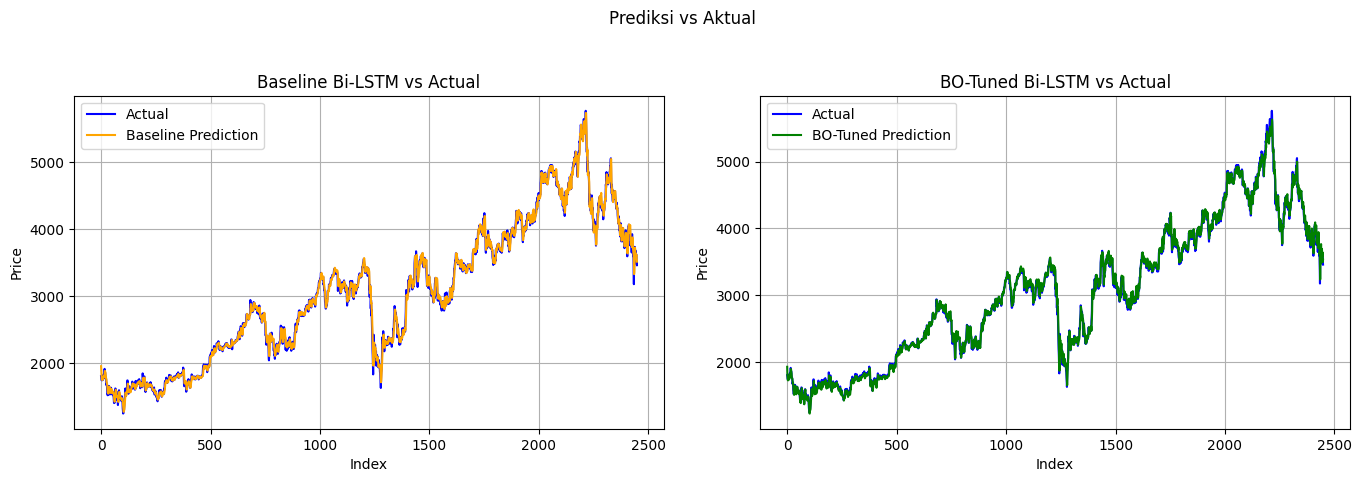

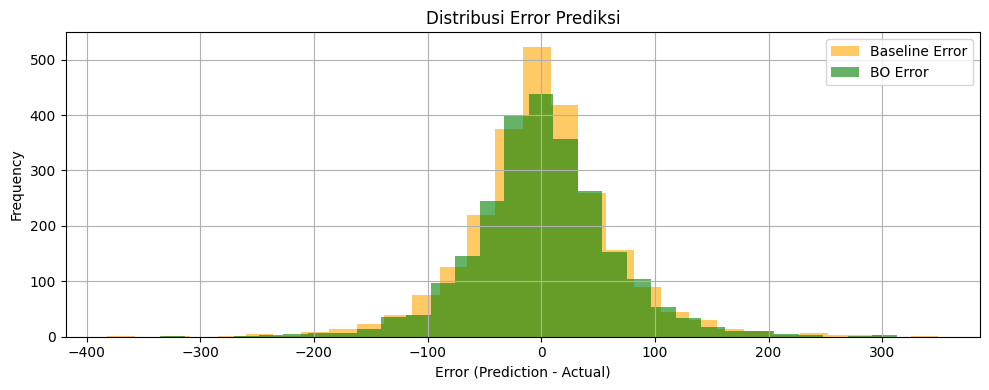

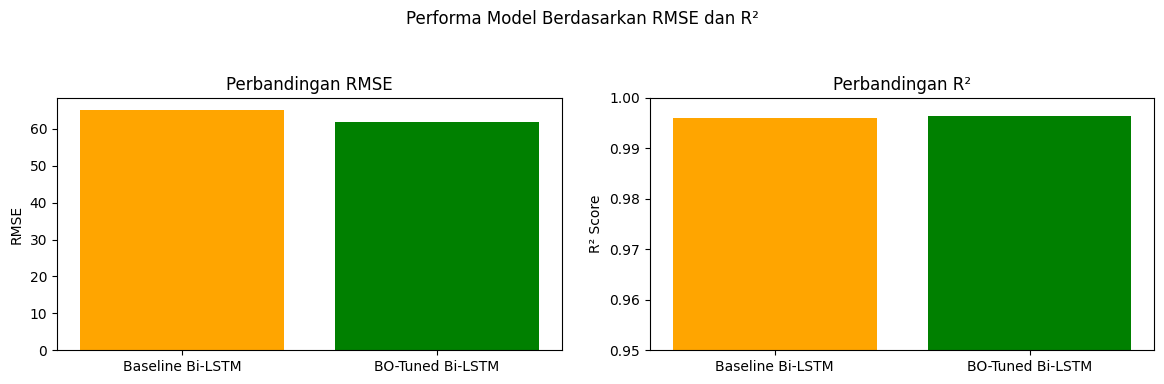

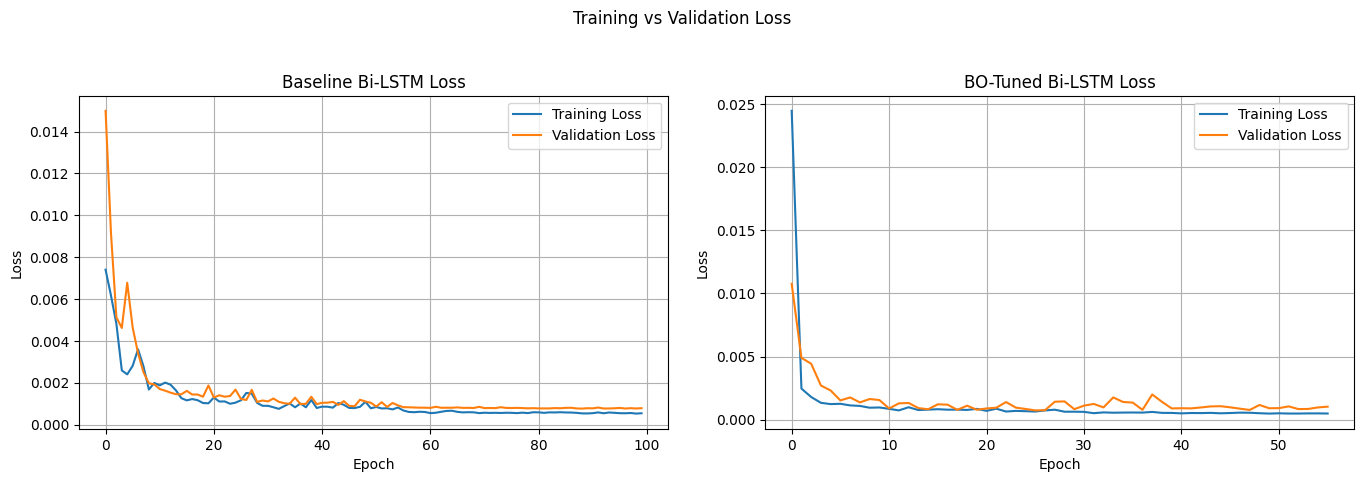

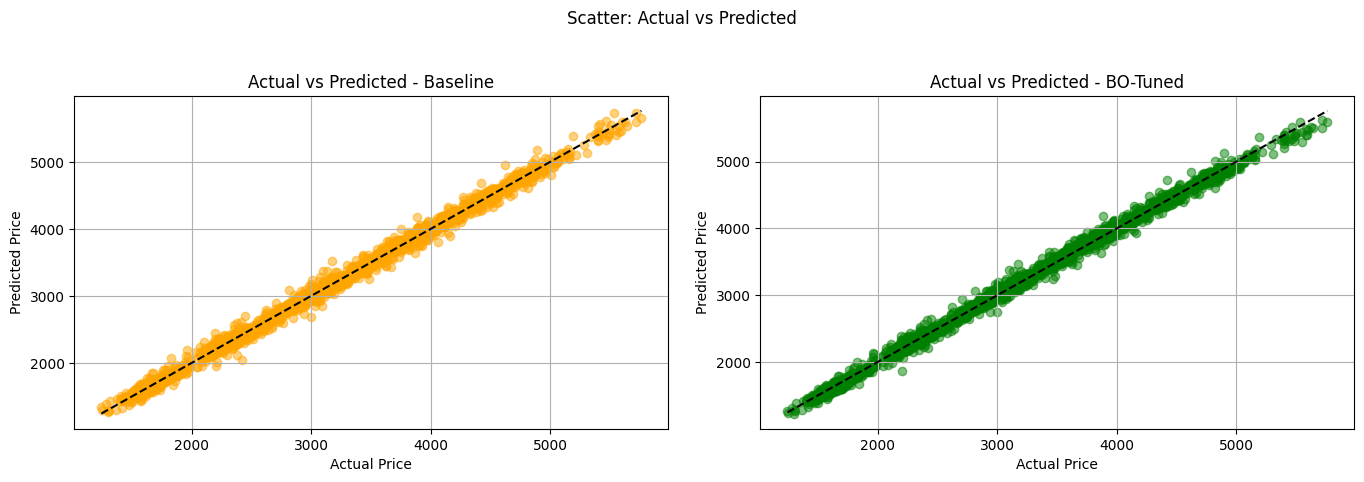

[*********************100%***********************]  1 of 1 completed



Evaluasi Recursive Forecast (SMA Murni):
- RMSE     : 247.18
- R² Score : -2.5939
- Korelasi : 0.6887
- MAPE     : 6.27%
- Akurasi  : 93.73%


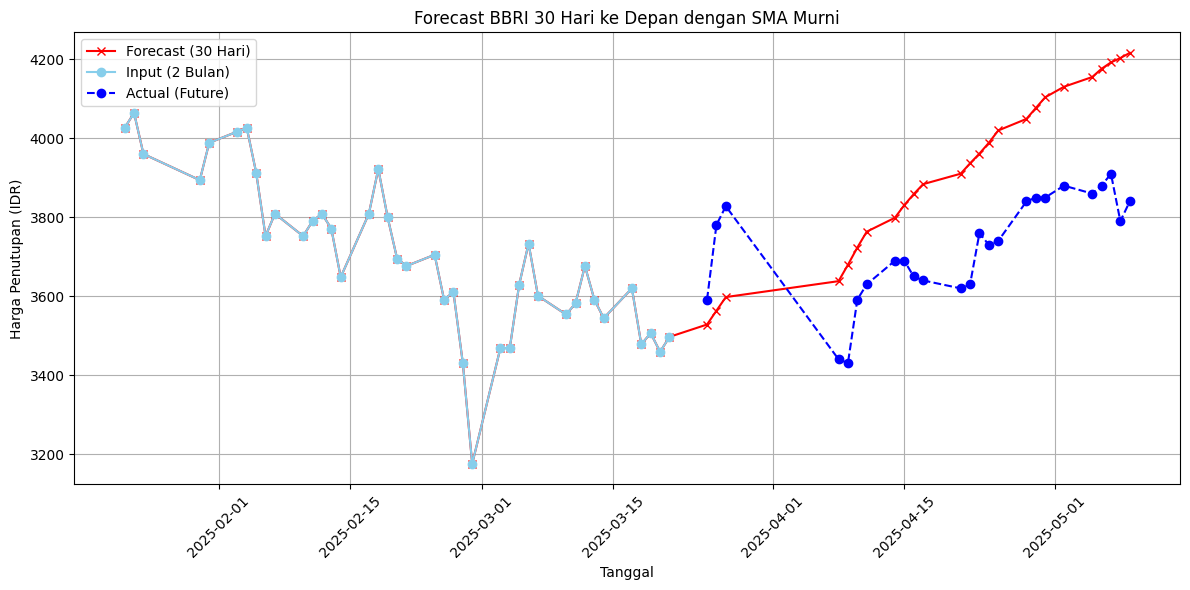

In [ ]:
# ============================ #
# TAHAP: ASSESSMENT FINAL + VALIDATION CHECK + RECURSIVE FORECAST
# ============================ #
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

import talib

# 1. Evaluasi model utama (training fit split)
rmse_baseline = np.sqrt(mean_squared_error(y_true_inv, y_pred_baseline_inv))
r2_baseline = r2_score(y_true_inv, y_pred_baseline_inv)

rmse_bo = np.sqrt(mean_squared_error(y_true_inv, y_pred_bo_inv))
r2_bo = r2_score(y_true_inv, y_pred_bo_inv)

comparison_df = pd.DataFrame({
    'Model': ['Baseline Bi-LSTM', 'BO-Tuned Bi-LSTM'],
    'RMSE': [rmse_baseline, rmse_bo],
    'R²': [r2_baseline, r2_bo]
})
print("\nTabel Evaluasi RMSE dan R²:")
print(comparison_df.to_string(index=False))

# 2. Evaluasi pada validation set (dipisah dari awal)
val_close = val_data['Close'].astype(float).values.flatten()
sma_20_val = talib.SMA(val_close, timeperiod=20)
sma_50_val = talib.SMA(val_close, timeperiod=50)

df_val_feat = pd.DataFrame({
    'Close': val_close,
    'SMA_20': sma_20_val,
    'SMA_50': sma_50_val
}).fillna(method='ffill').dropna()

val_scaled = scaler.transform(df_val_feat)
X_val, y_val = [], []
for i in range(len(val_scaled) - time_step - 1):
    X_val.append(val_scaled[i:i+time_step])
    y_val.append(val_scaled[i + time_step, 0])
X_val, y_val = np.array(X_val), np.array(y_val)

y_val_pred_scaled = bo_model.predict(X_val, verbose=0)
y_val_true_inv = scaler.inverse_transform(np.column_stack([y_val, np.zeros((len(y_val), 2))]))[:, 0]
y_val_pred_inv = scaler.inverse_transform(np.column_stack([y_val_pred_scaled.flatten(), np.zeros((len(y_val_pred_scaled), 2))]))[:, 0]

rmse_val = np.sqrt(mean_squared_error(y_val_true_inv, y_val_pred_inv))
r2_val = r2_score(y_val_true_inv, y_val_pred_inv)
corr_val, _ = pearsonr(y_val_true_inv, y_val_pred_inv)

print("\nEvaluasi Prediksi pada Validation Set:")
print(f"- RMSE        : {rmse_val:.2f}")
print(f"- R² Score    : {r2_val:.4f}")
print(f"- Korelasi    : {corr_val:.4f}")

# 3. Plot: Prediksi vs Aktual (Time Series)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(y_true_inv, label='Actual', color='blue')
plt.plot(y_pred_baseline_inv, label='Baseline Prediction', color='orange')
plt.title('Baseline Bi-LSTM vs Actual')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(y_true_inv, label='Actual', color='blue')
plt.plot(y_pred_bo_inv, label='BO-Tuned Prediction', color='green')
plt.title('BO-Tuned Bi-LSTM vs Actual')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid()

plt.suptitle("Prediksi vs Aktual")
plt.tight_layout(pad=2)
plt.show()

# 4. Distribusi Error
plt.figure(figsize=(10, 4))
plt.hist(y_pred_baseline_inv - y_true_inv, bins=30, alpha=0.6, label='Baseline Error', color='orange')
plt.hist(y_pred_bo_inv - y_true_inv, bins=30, alpha=0.6, label='BO Error', color='green')
plt.title('Distribusi Error Prediksi')
plt.xlabel('Error (Prediction - Actual)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 5. Bar Plot: RMSE & R²
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(comparison_df['Model'], comparison_df['RMSE'], color=['orange', 'green'])
axs[0].set_title("Perbandingan RMSE")
axs[0].set_ylabel("RMSE")
axs[1].bar(comparison_df['Model'], comparison_df['R²'], color=['orange', 'green'])
axs[1].set_title("Perbandingan R²")
axs[1].set_ylabel("R² Score")
axs[1].set_ylim(0.95, 1.00)
plt.suptitle("Performa Model Berdasarkan RMSE dan R²")
plt.tight_layout(pad=2)
plt.show()

# 6. Training vs Validation Loss
def plot_training_history(history, title):
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_training_history(history_baseline, "Baseline Bi-LSTM Loss")
plt.subplot(1, 2, 2)
plot_training_history(history_bo, "BO-Tuned Bi-LSTM Loss")
plt.suptitle("Training vs Validation Loss")
plt.tight_layout(pad=2)
plt.show()

# 7. Actual vs Predicted (Scatter)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_true_inv, y_pred_baseline_inv, alpha=0.5, color='orange')
plt.plot([min(y_true_inv), max(y_true_inv)], [min(y_true_inv), max(y_true_inv)], 'k--')
plt.title("Actual vs Predicted - Baseline")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(y_true_inv, y_pred_bo_inv, alpha=0.5, color='green')
plt.plot([min(y_true_inv), max(y_true_inv)], [min(y_true_inv), max(y_true_inv)], 'k--')
plt.title("Actual vs Predicted - BO-Tuned")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid()
plt.suptitle("Scatter: Actual vs Predicted")
plt.tight_layout(pad=2)
plt.show()

# ============================ #
# 8. Recursive Forecast + Evaluasi dari 2 Bulan Validation Terakhir
# ============================ #

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# --- Parameter ---
time_step = 40
n_days_forecast = 30

# --- Ambil 2 Bulan Terakhir dari Validation sebagai input ---
val_close = val_data['Close'].astype(float).values.flatten()

sma_20_val = talib.SMA(val_close, timeperiod=20)
sma_50_val = talib.SMA(val_close, timeperiod=50)

df_val_feat = pd.DataFrame({
    'Close': val_close,
    'SMA_20': sma_20_val,
    'SMA_50': sma_50_val
}).fillna(method='ffill').dropna()

val_scaled = scaler.transform(df_val_feat)
last_sequence = val_scaled[-time_step:]

# --- Recursive Forecast Function dengan SMA Murni ---
def recursive_forecast_with_manual_sma(model, input_sequence, n_days, scaler, last_closes):
    preds_scaled = []
    seq = input_sequence.copy()

    for _ in range(n_days):
        # Prediksi skala MinMax
        pred_scaled = model.predict(seq.reshape(1, *seq.shape), verbose=0)[0, 0]
        preds_scaled.append(pred_scaled)

        # Inverse untuk mendapatkan harga aktual
        pred_price = scaler.inverse_transform(
            np.column_stack([[pred_scaled], [0], [0]])
        )[:, 0][0]

        # Simpan prediksi ke list harga terakhir
        last_closes.append(pred_price)

        # Hitung SMA secara manual dari harga prediksi sebelumnya (MURNI)
        sma_20 = np.mean(last_closes[-20:]) if len(last_closes) >= 20 else np.mean(last_closes)
        sma_50 = np.mean(last_closes[-50:]) if len(last_closes) >= 50 else np.mean(last_closes)

        # Transform input baru dan update sequence
        new_input = scaler.transform([[pred_price, sma_20, sma_50]])[0]
        seq = np.append(seq[1:], [new_input], axis=0)

    # Inverse prediksi ke skala harga
    preds_final = scaler.inverse_transform(
        np.column_stack([preds_scaled, np.zeros((n_days, 2))])
    )[:, 0]

    return preds_final

# --- Jalankan Prediksi ---
last_closes = list(df_val_feat['Close'].values[-time_step:])
rec_preds_30d = recursive_forecast_with_manual_sma(
    bo_model,
    last_sequence,
    n_days_forecast,
    scaler,
    last_closes
)

# --- Ambil Harga Aktual dari Yahoo Finance ---
actual_data = yf.download("BBRI.JK", start="2025-03-25", end="2025-05-10")[['Close']]
actual_data.reset_index(inplace=True)
actual_data.columns = ['Date', 'Actual_Close']
actual_data['Date'] = pd.to_datetime(actual_data['Date']).dt.normalize()

# --- Bangun DataFrame untuk Evaluasi ---
min_len = min(len(rec_preds_30d), len(actual_data))
forecast_df = actual_data.iloc[:min_len].copy()
forecast_df['Forecast'] = rec_preds_30d[:min_len]

# --- Evaluasi ---
y_true = forecast_df['Actual_Close'].values
y_pred = forecast_df['Forecast'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
corr, _ = pearsonr(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
accuracy = 100 - mape

print("\nEvaluasi Recursive Forecast (SMA Murni):")
print(f"- RMSE     : {rmse:.2f}")
print(f"- R² Score : {r2:.4f}")
print(f"- Korelasi : {corr:.4f}")
print(f"- MAPE     : {mape:.2f}%")
print(f"- Akurasi  : {accuracy:.2f}%")

# --- Visualisasi ---
recent_dates = val_data.tail(time_step).index
recent_actuals = val_data.tail(time_step)['Close'].values.flatten()
dates_combined = list(recent_dates) + list(forecast_df['Date'])[:len(y_pred)]
values_combined = list(recent_actuals) + list(y_pred)
actual_future = list(forecast_df['Actual_Close'].values[:len(y_pred)])

plt.figure(figsize=(12, 6))
plt.plot(dates_combined, values_combined, label='Forecast (30 Hari)', color='red', marker='x')
plt.plot(recent_dates, recent_actuals, label='Input (2 Bulan)', color='skyblue', marker='o')
plt.plot(forecast_df['Date'][:len(y_pred)], actual_future, label='Actual (Future)', color='blue', linestyle='--', marker='o')
plt.title("Forecast BBRI 30 Hari ke Depan dengan SMA Murni")
plt.xlabel("Tanggal")
plt.ylabel("Harga Penutupan (IDR)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import os
import sys
import json
import joblib
import shutil
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Buat folder penyimpanan berdasarkan timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
base_dir = f"/content/drive/MyDrive/Model Forecast/{timestamp}"
os.makedirs(base_dir, exist_ok=True)

# 3. Simpan model (.h5)
bo_model.save(os.path.join(base_dir, "bo_model.h5"))

# 4. Simpan scaler (.pkl)
joblib.dump(scaler, os.path.join(base_dir, "scaler.pkl"))

# 5. Simpan log hasil BO (.csv)
if 'iteration_logs' in globals():
    pd.DataFrame(iteration_logs).to_csv(os.path.join(base_dir, "bo_iteration_logs.csv"), index=False)

# 6. Simpan plot training loss (.png)
plt.figure(figsize=(8, 4))
plt.plot(history_bo.history['loss'], label='Train Loss')
if 'val_loss' in history_bo.history:
    plt.plot(history_bo.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss (BO Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(os.path.join(base_dir, "training_loss_plot.png"))
plt.close()

# 7. Simpan best hyperparameters (.json)
with open(os.path.join(base_dir, "best_hyperparameters.json"), "w") as f:
    json.dump(best_params, f, indent=2)

# 8. Simpan dataset untuk retraining
np.save(os.path.join(base_dir, "X_train.npy"), X)
np.save(os.path.join(base_dir, "y_train.npy"), y)
if 'X_val' in globals() and 'y_val' in globals():
    np.save(os.path.join(base_dir, "X_val.npy"), X_val)
    np.save(os.path.join(base_dir, "y_val.npy"), y_val)

# 9. Simpan forecast dataframe
if 'forecast_df' in globals():
    forecast_df.to_csv(os.path.join(base_dir, "forecast_30d.csv"), index=False)

# 10. Simpan evaluasi metrik (.json)
eval_result = {
    "train_RMSE": float(rmse_bo),
    "train_R2": float(r2_bo),
    "val_RMSE": float(rmse_val),
    "val_R2": float(r2_val),
    "val_corr": float(corr_val),
    "val_MAPE": float(mape),
    "val_accuracy": float(accuracy)
}
with open(os.path.join(base_dir, "evaluation_metrics.json"), "w") as f:
    json.dump(eval_result, f, indent=2)

# 11. Simpan konfigurasi pipeline (.json)
config = {
    "model_type": "Bi-LSTM",
    "time_step": time_step,
    "features": list(df_feat.columns),
    "data_end_date": str(data.index[-1].date()),
    "train_ratio": 0.6,
    "val_ratio": 0.2,
    "test_ratio": 0.2,
    "forecast_horizon": 30
}
with open(os.path.join(base_dir, "pipeline_config.json"), "w") as f:
    json.dump(config, f, indent=2)

# 12. Simpan ringkasan model (.txt)
with open(os.path.join(base_dir, "model_summary.txt"), "w") as f:
    bo_model.summary(print_fn=lambda x: f.write(x + '\n'))

# 13. Simpan training history (.json)
with open(os.path.join(base_dir, "training_history.json"), "w") as f:
    json.dump(history_bo.history, f, indent=2)

# 14. Simpan ruang pencarian BO (.json)
search_space = {
    "hidden_units": "(16, 64)",
    "dropout_rate": "(0.1, 0.4)",
    "learning_rate": "(0.0005, 0.01)"
}
with open(os.path.join(base_dir, "bo_search_space.json"), "w") as f:
    json.dump(search_space, f, indent=2)

# 15. Simpan info lingkungan (.json)
env = {
    "random_seed": SEED,
    "tensorflow_version": tf.__version__,
    "numpy_version": np.__version__,
    "pandas_version": pd.__version__,
    "python_version": sys.version
}
with open(os.path.join(base_dir, "environment_info.json"), "w") as f:
    json.dump(env, f, indent=2)

# 16. Simpan visualisasi forecast (.png)
if 'forecast_df' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_df['Date'], forecast_df['Actual_Close'], label='Actual', marker='o', color='blue')
    plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', marker='x', color='red')
    plt.title("Recursive Forecast vs Harga Aktual (30 Hari)")
    plt.xlabel("Tanggal")
    plt.ylabel("Harga Penutupan")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "forecast_plot.png"))
    plt.close()

# 17. Simpan log training jika ada (opsional)
if 'training_logs' in globals():
    with open(os.path.join(base_dir, "training_log.txt"), "w") as f:
        for line in training_logs:
            f.write(str(line) + "\n")

# 18. Simpan confusion matrix arah naik/turun (opsional)
if 'y_val_true_inv' in globals() and 'y_val_pred_inv' in globals():
    actual_dir = np.where(np.diff(y_val_true_inv, prepend=y_val_true_inv[0]) > 0, 1, 0)
    pred_dir = np.where(np.diff(y_val_pred_inv, prepend=y_val_pred_inv[0]) > 0, 1, 0)
    cm = confusion_matrix(actual_dir, pred_dir)
    np.save(os.path.join(base_dir, "confusion_matrix.npy"), cm)

# 19. Simpan file manifest (daftar isi)
with open(os.path.join(base_dir, "file_manifest.txt"), "w") as f:
    for root, dirs, files in os.walk(base_dir):
        for name in files:
            f.write(os.path.relpath(os.path.join(root, name), base_dir) + '\n')

# 20. Simpan file README.txt
readme_text = f"""
Forecasting Model - BBRI Bi-LSTM
==================================
Tanggal Training   : {timestamp}
Model              : Bidirectional LSTM
Forecast Horizon   : 30 hari
Time Step Input    : {time_step}
Data Terakhir      : {config['data_end_date']}

File yang Disimpan:
- Model & Scaler       : bo_model.h5, scaler.pkl
- Dataset & Forecast   : X_train.npy, y_train.npy, forecast_30d.csv
- Evaluasi & Visual    : evaluation_metrics.json, training_loss_plot.png, forecast_plot.png
- Metadata & Config    : best_hyperparameters.json, pipeline_config.json, model_summary.txt
- Log & History        : training_history.json, training_log.txt (opsional), confusion_matrix.npy (opsional)
- Lingkungan & Versi   : environment_info.json, python_version, file_manifest.txt

Siap digunakan untuk retraining, evaluasi ulang, dokumentasi, atau deployment.
"""
with open(os.path.join(base_dir, "README.txt"), "w") as f:
    f.write(readme_text)

# 21. Simpan ZIP arsip folder
shutil.make_archive(base_dir, 'zip', base_dir)

# 21b. Simpan versi TensorFlow Lite (.tflite) untuk deployment ringan (opsional)
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(bo_model)
    tflite_model = converter.convert()
    with open(os.path.join(base_dir, "bo_model.tflite"), "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Gagal konversi ke .tflite: {e}")

# 21c. Simpan hash model (.txt) untuk tracking versi
import hashlib
try:
    with open(os.path.join(base_dir, "bo_model.h5"), "rb") as f:
        model_hash = hashlib.md5(f.read()).hexdigest()
    with open(os.path.join(base_dir, "model_hash.txt"), "w") as f:
        f.write(model_hash)
except Exception as e:
    print(f"Gagal membuat hash model: {e}")

# 21d. Simpan log format standar untuk tracking MLOps (mlops_log.json)
mlops_log = {
    "timestamp": timestamp,
    "model_name": "bi_lstm_bbri",
    "rmse_val": float(rmse_val),
    "r2_val": float(r2_val),
    "features": config["features"],
    "data_end": config["data_end_date"],
    "forecast_horizon": config["forecast_horizon"],
    "params": best_params,
    "hash": model_hash if 'model_hash' in locals() else "N/A"
}
with open(os.path.join(base_dir, "mlops_log.json"), "w") as f:
    json.dump(mlops_log, f, indent=2)

# 21e. Simpan hasil ke Excel untuk non-programmer
try:
    with pd.ExcelWriter(os.path.join(base_dir, "forecast_output.xlsx")) as writer:
        if 'forecast_df' in globals():
            forecast_df.to_excel(writer, sheet_name='Forecast', index=False)
        if 'iteration_logs' in globals():
            pd.DataFrame(iteration_logs).to_excel(writer, sheet_name='BO_Logs', index=False)
        pd.DataFrame([eval_result]).to_excel(writer, sheet_name='Eval_Metrics', index=False)
except Exception as e:
    print(f"Gagal ekspor ke Excel: {e}")


# 22. Konfirmasi akhir
print(f"Semua file berhasil disimpan di: {base_dir}")

Mounted at /content/drive


Saved artifact at '/tmp/tmpnl9zvhk7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 3), dtype=tf.float32, name='keras_tensor_244')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140048248920144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048248920528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048248915920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048248919760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048248914000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048248927248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048248929360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140048156047120: TensorSpec(shape=(), dtype=tf.resource, name=None)
⚠️ Gagal konversi ke .tflite: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "sequential_61_1/bidirecti